# Preliminary work

- I found one of the datasets from the paper
- I chose 1 of the features which seemed most appropriate for a polynomial fit for linear regression (basically exactly what the paper did)
- Below is some preliminary work where I conduct standard linear regression and then polynomial linear regression using existing package sklearn
- I show MSE for both fits


- We will be doing linear regression in this notebook: $y = X\beta + \epsilon$
- We will be choosing only a single regressor to predict the dependent variable
- We have chosen a dataset which requires polynomial linear regression
- As a result the line we're trying to fit is $y=\beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \epsilon$
- Need to transform (N * 1) matrix $X$ to (N * 4) matrix as a result where ith row is $\begin{bmatrix} 1 & x_i & x_i^2 & x_i^3 \end{bmatrix}$
- After this transformation, initially we will use the closed form solution for the Least Squares Estimator to fit the data: $\hat{\beta} = (X^T X)^{-1}X^T y$
    - Here $\hat{\beta} = \begin{bmatrix} \hat{\beta_0} \\ \hat{\beta_1} \\ \hat{\beta_2} \\ \hat{\beta_3} \end{bmatrix}$
- Then we move onto an iterative gradient descent approach for LSE Estimation of Linear Regression. SGD is one of the algorithms here!
    - Batch Gradient Descent where we use the entire dataset: $\hat{\beta}_{k+1} = \hat{\beta}_{k} - \alpha X^T(\hat{y} - y)$
        - $\hat{\beta}_{k} = \begin{bmatrix} \hat{\beta_0}_{k} \\ \hat{\beta_1}_{k} \\ \hat{\beta_2}_{k} \\ \hat{\beta_3}_{k} \end{bmatrix}, y = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}, X = \begin{bmatrix} 1 & x_1 & x_1^2 & x_1^3 \\ 1 & x_2 & x_2^2 & x_2^3 \\ \vdots & \ddots \\ 1 & x_n & x_n^2 & x_n^3 \end{bmatrix}$
    - Stochastic Gradient Descent where we use just a single randomly selected sample: $\hat{\beta}_{k+1} = \hat{\beta}_{k} - \alpha(\hat{y_i} - y) x_i^T$
        - Now the $y, y_i$ are both scalar, and $x_i$ is not a matrix but rather a vector of a single randomly selected row from $X$

In [291]:
import os
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import random
from multiprocessing import Process, Pool
import time
import workers
import SGD_Zinkevich
from datetime import datetime
import math
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

In [292]:
dataframe = pd.read_excel('dataset1/dataset1.xlsx')
print(dataframe.shape)
dataframe.describe()

(9568, 5)


,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [332]:
X = dataframe['V'].sort_values()
X = (X-X.mean()) / X.std()
y = dataframe['AT'][X.index].values
y = (y-y.mean()) / y.std()

X = np.reshape(X.values, (-1,1))

In [ ]:
plt.scatter(X, y)
plt.xlabel("Exhaust Vacuum")
plt.ylabel("Average Temperature")
plt.show()

In [333]:
lr = LinearRegression()
lr.fit(X, y)
y_hat_sklearn = lr.predict(X)

pr = PolynomialFeatures(degree=3)
X_poly = pr.fit_transform(X)
lr_poly = LinearRegression()
lr_poly.fit(X_poly, y)
y_hat_poly_sklearn = lr_poly.predict(X_poly)


In [ ]:
plt.scatter(X, y, color = 'blue')
plt.plot(X, y_hat_sklearn, color = 'firebrick')
plt.plot(X, y_hat_poly_sklearn, color = 'green')
plt.show()

In [318]:
y_hat_sklearn = lr.predict(X)
y_hat_poly_sklearn = lr_poly.predict(X_poly)

print("mean squared error for standard linear:", mean_squared_error(y, y_hat_sklearn))
print("mean squared error for linear polynomial:", mean_squared_error(y, y_hat_poly_sklearn))

mean squared error for standard linear: 0.28748382521534876
mean squared error for linear polynomial: 0.27181848231219186


# Going from built-in package to implementing it ourselves

- Now using the dataset, I will conduct linear regression, but this time using matrix multiplication and numpy.
- I will implement a closed-form based based algorithm before moving onto a gradient descent based algorithm.

In [319]:
'''
Converts an (N * 1) matrix into a (N * h) matrix where h is the number of basis functions ()
The degree of the polynomial is (h-1)
'''
def polynomial_basis_function_transformation(X, h):
    powers = np.arange(h)
    X_poly = np.power(X, powers)
    return X_poly

'''
Conducts Linear Regression but initially transforms data using polynomial basis functions
Takes in an (N * 1) matrix, converts it into a (N * h) matrix
Performs linear regression on the (N*h) matrix resulting in h weights - betas
Returns the predictions only
'''
def lin_reg_poly_closed_form(X, y, h):
    X_poly = polynomial_basis_function_transformation(X, h)
    beta_hat_poly = np.linalg.pinv(X_poly.T @ X_poly) @ X_poly.T @ y
    y_hat_poly = X_poly @ beta_hat_poly
    return y_hat_poly


In [320]:
y_hat_poly = lin_reg_poly_closed_form(X, y, 4)

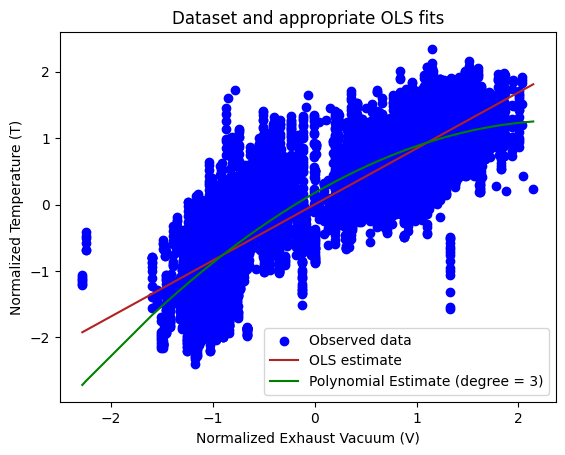

mean squared error for linear polynomial through numpy (closed form): 0.2718184823121919


In [342]:
plt.scatter(X, y, color = 'blue', label="Observed data")
plt.plot(X, y_hat_sklearn, color = 'firebrick', label="OLS estimate")
plt.plot(X, y_hat_poly, color = 'green', label='Polynomial Estimate (degree = 3)')
plt.title("Dataset and appropriate OLS fits")
plt.ylabel("Normalized Temperature (T)")
plt.xlabel("Normalized Exhaust Vacuum (V)")
plt.legend()
plt.show()

print("mean squared error for linear polynomial through numpy (closed form):", mean_squared_error(y, y_hat_poly))

# Implementing the Batch Gradient Descent algorithm for linear regression

- We have implemented the closed form solution for polynomial linear regression ourselves above, moving away from sklearn as a package
- We now look to implement an iterative algorithm, useful when closed form solution is computationally prohibitive, such as when $X^TX$ is $10,000*10,000$ leading to matrix inversion times being extremely long (in the above case it is only $4 * 4$)
- We will initially implement Batch Gradient Descent and parallelize it before finally moving onto Stochastic Gradient Descent, and then parallelizing Stochastic Gradient Descent

## Non Parallelized version

In [336]:
'''
Conducts Linear Regression but initially transforms data using polynomial basis functions
Takes in an (N * 1) matrix, converts it into a (N * h) matrix
Performs linear regression on the (N*h) matrix resulting in h weights - betas
But this time linear regression is conducted through iterative batch gradient descent
MSE as you iterate through the algorithm is shown
Returns the predictions only
'''
def lin_reg_poly_bgd(X, y, h, alpha, n):
    X_poly = polynomial_basis_function_transformation(X, h)
    beta_hat_poly = np.random.rand(h)
    for i in range(n):
        y_hat_poly = X_poly @ beta_hat_poly
        beta_hat_poly = beta_hat_poly - alpha * (X_poly.T @ (y_hat_poly - y))
        print("MSE in iteration", i, ": ", mean_squared_error(y, y_hat_poly))
    return y_hat_poly
    

In [339]:
y_hat_poly_bgd = lin_reg_poly_bgd(X, y, 4, 0.00001, 5000)

MSE in iteration 0 :  3.493996401268229
MSE in iteration 1 :  1.8906482906550561
MSE in iteration 2 :  1.1674530352547972
MSE in iteration 3 :  0.8118005040972854
MSE in iteration 4 :  0.6217407851333849
MSE in iteration 5 :  0.5129245939821526
MSE in iteration 6 :  0.44734265178230387
MSE in iteration 7 :  0.40634619094499463
MSE in iteration 8 :  0.38001354969287515
MSE in iteration 9 :  0.36270630814582283
MSE in iteration 10 :  0.3510654231729099
MSE in iteration 11 :  0.3430273778025553
MSE in iteration 12 :  0.33730044916385205
MSE in iteration 13 :  0.33306696727475926
MSE in iteration 14 :  0.3298059140725872
MSE in iteration 15 :  0.32718395234943576
MSE in iteration 16 :  0.32498723337307406
MSE in iteration 17 :  0.3230782558542923
MSE in iteration 18 :  0.321368402500371
MSE in iteration 19 :  0.3198003950357803
MSE in iteration 20 :  0.31833706331274225
MSE in iteration 21 :  0.3169541481157189
MSE in iteration 22 :  0.3156356859356012
MSE in iteration 23 :  0.314371048286

In [330]:
print(y_hat_poly_bgd)

[nan nan nan ... nan nan nan]


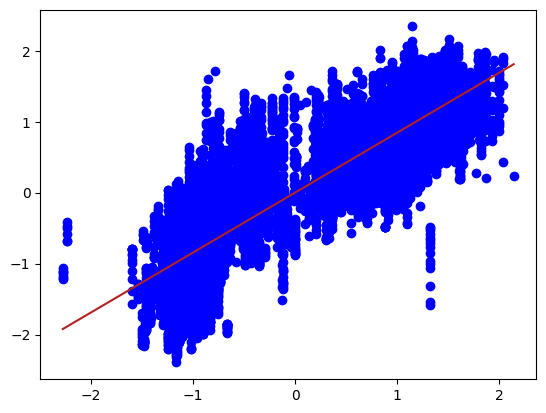

ValueError: Input contains NaN.

In [329]:
plt.scatter(X, y, color = 'blue')
plt.plot(X, y_hat_sklearn, color = 'firebrick')
plt.plot(X, y_hat_poly_bgd, color = 'green')
plt.show()

print("mean squared error for linear polynomial through numpy (gradient descent):", mean_squared_error(y, y_hat_poly_bgd))

## Parallelized version
- We now implement the parallelized version of Batch Gradient Descent
- We can expect to see clear advantages to the Batch Gradient Descent algorithm when using parallelization

# Stochastic Gradient Descent
- We will now implement the non-parallelized version of SGD

## Non-Parallelized Version

In [5]:
'''
Conducts Linear Regression but initially transforms data using polynomial basis functions
Takes in an (N * 1) matrix, converts it into a (N * h) matrix
Performs linear regression on the (N*h) matrix resulting in h weights - betas
But this time linear regression is conducted through iterative gradient descent
Specifically stochastic gradient descent where we just choose a single sample from the the dataset
MSE as you iterate through the algorithm is shown
Returns the predictions only
'''
def lin_reg_poly_sgd(X, y, h, alpha, n):
    X_poly = polynomial_basis_function_transformation(X, h)
    beta_hat_poly = np.random.rand(h)
    for i in range(n):
        idx = np.random.randint(0, X_poly.shape[0])
        X_sample = X_poly[idx, :]
        y_sample = y[idx]
        y_hat_sample_poly = X_sample @ beta_hat_poly
        beta_hat_poly = beta_hat_poly - alpha * (X_sample.T * (y_hat_sample_poly - y_sample))
        
        y_hat_poly = X_poly @ beta_hat_poly
        if i % 100000 == 0:
            print("MSE in iteration", i, ": ", mean_squared_error(y, y_hat_poly))
    return y_hat_poly

In [ ]:
start = datetime.now()
lin_reg_poly_sgd(X, y, 4, 0.00001, 50000000)
diff = datetime.now() - start
print(diff)

## Example of the Multiprocessing library
- Here is a very simple example of how to use multiprocessing
- Note that the actual function which the worker processes in parallel HAS TO BE IN ANOTHER FILE
- This is why workers.py and SGD_Zinkevich.py exists
- Try by changing workers.f to just f and f2 defined in this notebook. You will see what I mean

In [ ]:
def info(title):
    print(title)
    print('module name:', __name__)
    print('parent process:', os.getppid())
    print('process id:', os.getpid())
    
    
def f(name):
    print("hello bob1")
    info('function f')
    print()
    
def f2(name):
    time.sleep(5)
    print("hello bob2")
    info('function f')
    print()

workers.info('main line')
p1 = Process(target=workers.f, args=('bob1',))
p2 = Process(target=workers.f2, args=('bob2',))

p2.start()
p1.start()
p2.join()
p1.join()

## Zinkevich et al's attempt at parallelizing SGD
- Implementing parallelization of SGD according to the paper "Parallelized Stochastic Gradient Descent" published by Zinkevich et al (References in report).
- We have extended upon the results achieved by the paper slightly. The procedure is explained below

### Preliminary
- Please read the descriptions before each function and try understand what each function does
    - lin_reg_poly_sgd_parallel implements the parallel SGD algorithm with t processes for n iterations. Returns the MSE after n iterations.
    - get_mse_mean_var implements the parallel SGD algorithm with t processes for n iterations an i amount of times and returns the sample mean of MSEs and sample variance of MSEs.
    - mse_mean_var_evolution allows us to see the evolution of the average and sample variance of MSEs as you increase the iterations. This provides us snapshots of model performances throughout training for different process counts in the parallel SGD algorithm.

### Procedure
1. Repeat the below for t = 1, 2, 4, 8 (We conduct the experiment for 1 process, 2 processes, 4 processes, 8 processes in the algorithm).
2. Call mse_mean_var_evolution() with the above different values of t. This tells us how the training process evolves when using different number of processes achieving parallelism. Each call to mse_mean_var_evolution returns an array of MSE means and variances, each as you increase n or in other words, as train the model longer.
3. We plot the array of MSE means and MSE variances for different process counts on the same plot allowing us to compare.

### Results
We successfully replicated results achieved by Zinkevich et al. He noticed that theoretically as you increase processor count, you should achieve a reduction in variance for a fixed iteration n. He also noted that you should observe a lower mean MSE as you increase the process count. This is the performance benefit to parallelism - we see better performances earlier on in training as a result of the parallelism. This is because we train t models in parallel, resulting in t models seeing different subsets of the data. In the end when you aggregate all the models, the resulting model will have seen more of the data in the same wall clock time compared to a model with a lower process count. However the benefits of parallelism diminish after you train for an extended amount of time as performances of all models converge to the lowest reference MSE as seen in Batch Gradient Descent.

In [299]:
'''
Conducts Linear Regression but initially transforms data using polynomial basis functions.
Takes in an (N * 1) matrix, converts it into a (N * h) matrix
Performs linear regression on the (N*h) matrix resulting in h weights - betas
But this time linear regression is conducted through an iterative gradient descent algorithm. 
Specifically stochastic gradient descent where we just choose a single sample from the the dataset.

This time t processes conduct SGD in parallel on the entire dataset exactly like the procedure in Zinkevich et al. 
Each process updates parameters for n iterations.

After each thread has returned estimates beta_hats, we aggregate them to get the final beta_hat

Returns the MSE and time it took for parallel computations as we are only measuring performance.
'''

def lin_reg_poly_sgd_parallel(X, y, h, alpha, n, t):
    start = datetime.now()
    
    X_poly = polynomial_basis_function_transformation(X, h)
    
    # Diff1 is the amount of time it took to do the matrix multiplication
    curr1 = datetime.now()
    diff1 = curr1 - start
    
    with Pool(processes=t) as p:
        # Diff2 is the amount of time it took to create a pool of t processes
        curr2 = datetime.now()
        diff2 = curr2 - curr1
        
        outputs = p.starmap(SGD_Zinkevich.lin_reg_poly_sgd, [[X_poly, y, h, alpha, n]] * t)
        outputs = np.array(outputs)
        
        # Diff3 is the amount of time it took to process t SGD algorithms in parallel in a pool of t processes
        curr3 = datetime.now()
        diff3 = curr3 - curr2
        
    beta_hat_poly = np.sum(outputs, axis=0) / t
    y_hat_poly = X_poly @ beta_hat_poly
    
    return mean_squared_error(y, y_hat_poly), diff2 + diff3

In [301]:
'''
This function calls the above function but for i amount of times.
Lets say we wanted to test the parallelized SGD algorithm after 1000 iterations of the dataset. 
We want to measure the benefits of parallelism for SGD so rationally we look at the MSE after conducting the parallel SGD algorithm (as described by the paper) with 1 process(equivalent to non parallel SGD), 2 processes, 4 processes, 8 processes, etc.
But running the SGD algorithm with t processes for n iterations twice will result in two different MSEs. This is because of the inherent stochastic nature of the algorithm where we randomly sample an observation.
Hence to get a more informative measure of the performance of the parallelized SGD algorithm with t processes after n iterations, we need to repeat the experiment i times, and obtain a sample of the MSEs, and then calculate the mean and the variance.
Comparing the mean of the MSE samples of two different stochastic models after n iterations makes more sense than comparing single observations of the MSEs.
We also compare the variances, and desire such that the variances of the MSE samples reduces as we increase the number of processes t used in training a model. This indicates that parallelism has some benefit.
'''

def get_mse_mean_var(X, y, h, alpha, n, t, i):
    mses = []
    times = []
    for i in range(i):
        mse, time_taken = lin_reg_poly_sgd_parallel(X, y, h, alpha, n, t)
        mses.append(mse)
        times.append(time_taken)
    mses = np.array(mses)
    times = np.array(times)
    return np.mean(mses), np.var(mses), np.mean(times)
    
    
'''
We have discussed how the above function measures the performance of a parallelized SGD algorithm with t threads after n iterations.
We want to see if parallelism has any sort of benefit throughout training, i.e. if we obtain a lower average MSE for the same number of iterations for a model with a higher process count, or maybe a lower variance of MSE for a higher process count if the MSEs are the same after n iterations.
Hence the below function implements the above function but gives us snapshots of model performance throughout training. This is allowing us to see the evolution of the performance (through average MSE) for different models throughout training.
'''
def mse_mean_var_evolution(X, y, h, alpha, n, t, i, means, variances, times):
    x_ = [10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000]
    for x in x_:
        mean, var, time_mean = get_mse_mean_var(X, y, h, alpha, x, t, i)
        means.append(mean)
        variances.append(var)
        times.append(time_mean)
        print(means)
        print(variances)
        print(times)

NOTE: The below cell took 8 minutes to run on apple M1 Macbook air

In [300]:
means1 = []
variances1 = []
times1 = []
mse_mean_var_evolution(X, y, 4, 0.0001, 10, 1, 100, means1, variances1, times1)

MSE in iteration 0 :  1.6286612274436925 in process id 88892
MSE in iteration 0 :  2.314461794439011 in process id 88915
MSE in iteration 0 :  5.0030517407343265 in process id 88927
MSE in iteration 0 :  2.5248215631644233 in process id 88928
MSE in iteration 0 :  1.1184937236823709 in process id 88929
MSE in iteration 0 :  5.004597584077366 in process id 88940
MSE in iteration 0 :  1.7849291695518 in process id 88942
MSE in iteration 0 :  4.072939856213257 in process id 88943
MSE in iteration 0 :  2.1868931350910397 in process id 88945
MSE in iteration 0 :  3.8674091934823283 in process id 88957
MSE in iteration 0 :  1.86928016176787 in process id 88958
MSE in iteration 0 :  5.886927674147408 in process id 88959
MSE in iteration 0 :  1.5217503958087508 in process id 88971
MSE in iteration 0 :  3.3744732345694946 in process id 88972
MSE in iteration 0 :  1.7397345401208175 in process id 88973
MSE in iteration 0 :  2.3707448549870698 in process id 88985
MSE in iteration 0 :  1.462051307

NOTE: The below cell took 9:15 minutes to run on apple M1 Macbook air

In [302]:
means2 = []
variances2 = []
times2 = []
mse_mean_var_evolution(X, y, 4, 0.0001, 10, 2, 100, means2, variances2, times2)

MSE in iteration 0 MSE in iteration:   0 6.027956325750459:   in process id 96758
2.3870817777131896 in process id 96757
MSE in iterationMSE in iteration  00  : :   3.240951550472049 in process id 96760
1.4543381315142292 in process id 96759
MSE in iteration 0 :  3.6868021214457602 in process id 96772
MSE in iteration 0 :  2.5408536284618113 in process id 96773
MSE in iteration 0 :  1.522571987746681 in process id 96774
MSE in iteration 0 :  3.8234766270885086 in process id 96775
MSE in iteration 0 :  2.294154351604386 MSE in iteration in process id0  : 96776 
2.483440902741152 in process id 96777
MSE in iteration 0MSE in iteration 0  : :   5.600356215051175 in process id 2.325900696109505496790 
in process id 96791
MSE in iterationMSE in iteration  00  : :   5.9038283526238493.510601010627172 in process id 96793 
in process id 96792
MSE in iteration 0 :  3.245720946408693 in process id 96794
MSE in iteration 0 :  2.294839380014418 in process id 96795
MSE in iteration 0 :  4.9801156604

NOTE: The below cell took 12:35 minutes to run on apple M1 Macbook air

In [303]:
means4 = []
variances4 = []
times4 = []
mse_mean_var_evolution(X, y, 4, 0.0001, 10, 4, 100, means4, variances4, times4)

MSE in iteration 0 :  5.432856326574463 in process id 7673
MSE in iteration 0 :  2.360177702226006 in process id 7671
MSE in iteration 0 :  1.0412126243570412 in process id 7672
MSE in iteration 0 :  4.541392752070906 in process id 7669
MSE in iteration 0 :  1.272991418245703 in process id 7686
MSE in iteration 0 :  2.7405719128026904 in process id 7685
MSE in iteration 0 :  4.706726564350667 in process id 7687
MSE in iteration 0 :  0.7559870071142772 in process id 7688
MSE in iteration 0 :  5.3027751020624665 in process id 7689
MSE in iteration 0 :  3.870233502253987 in process id 7690
MSE in iteration 0 :  2.882011667708543 in process id 7691
MSE in iteration 0 :  4.071543955031236 in process id 7692
MSE in iteration 0 :  2.192168267061507 in process id 7707
MSE in iteration 0 :  3.35197009604443 in process id 7706
MSE in iteration 0 :  3.09219145702493 in process id 7704
MSE in iteration 0 :  4.02133130852326 in process id 7705
MSE in iteration 0 :  2.1017869287097457 in process id 

NOTE: The below cell took 23 minutes to run on apple M1 Macbook air

In [304]:
means8 = []
variances8 = []
times8 = []
mse_mean_var_evolution(X, y, 4, 0.0001, 10, 8, 100, means8, variances8, times8)

MSE in iteration 0 :  4.096309950505586 in process id 21378
MSE in iteration 0 :  3.2585284277783013 in process id 21381
MSE in iteration 0 :  3.086569277344744 in process id 21377
MSE in iteration 0 :  4.000188648038107 in process id 21383
MSE in iteration 0 :  1.1609083563523397 in process id 21384
MSE in iteration 0 :  1.1828401027820785 in process id 21380
MSE in iteration 0 :  2.1250907010234403 in process id 21382
MSE in iteration 0 :  4.988050776531328 in process id 21379
MSE in iteration 0 :  3.7616030463170538 in process id 21413
MSE in iteration 0 :  1.7601911727893238 in process id 21412
MSE in iteration 0 :  1.9549758071577419 in process id 21416
MSE in iteration 0 :  1.3422212465229684 in process id 21414
MSE in iteration 0 :  3.878050022737479 in process id 21417
MSE in iteration 0 :  0.7719257501158123 in process id 21420
MSE in iteration 0 :  4.18566338953557 in process id 21419
MSE in iteration 0 :  0.870970663978298 in process id 21415
MSE in iteration 0 :  4.78210969

In [313]:
times1 = list(map(lambda x: x.total_seconds(), times1))
times2 = list(map(lambda x: x.total_seconds(), times2))
times4 = list(map(lambda x: x.total_seconds(), times4))
times8 = list(map(lambda x: x.total_seconds(), times8))

In [316]:
print(times1)
print(times8)

[0.683168, 0.628407, 0.667778, 0.681984, 0.715938, 0.742107, 0.757298, 0.799297, 0.883966, 0.955335]
[1.667086, 1.763338, 1.735997, 1.67653, 1.742972, 1.840807, 1.958802, 2.101673, 2.317041, 2.509134]


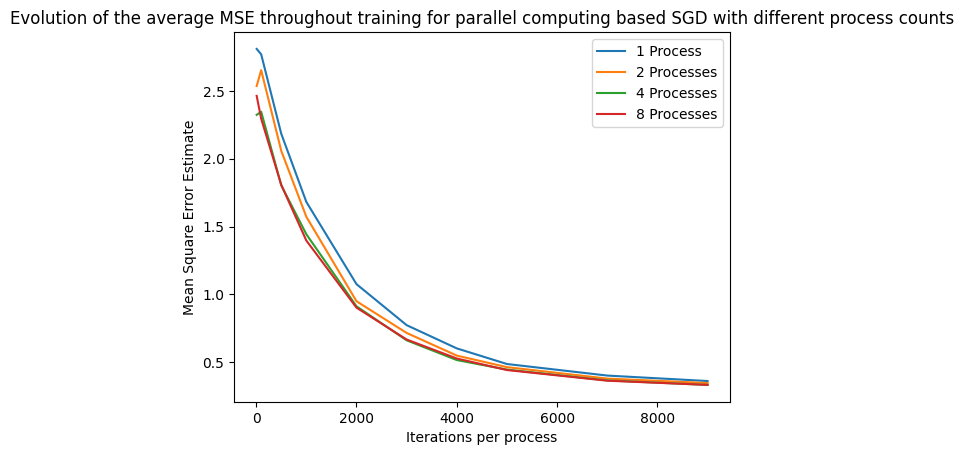

In [305]:
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], means1, label = "1 Process")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], means2, label = "2 Processes")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], means4, label = "4 Processes")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], means8, label = "8 Processes")
plt.title("Evolution of the average MSE throughout training for parallel computing based SGD with different process counts")
plt.ylabel("Mean Square Error Estimate")
plt.xlabel("Iterations per process")
plt.legend()
plt.show()

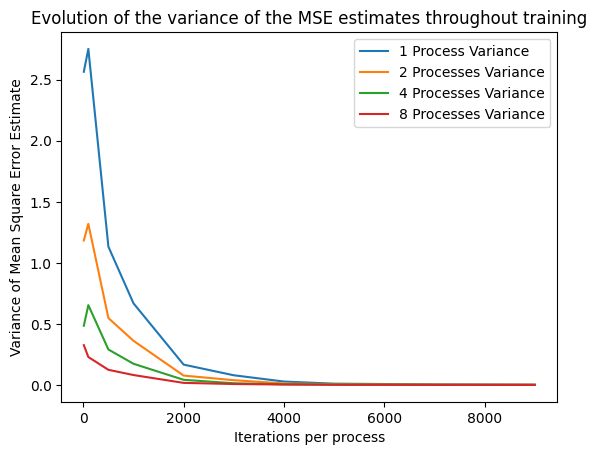

In [306]:
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances1, label = "1 Process Variance")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances2, label = "2 Processes Variance")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances4, label = "4 Processes Variance")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances8, label = "8 Processes Variance")
plt.title("Evolution of the variance of the MSE estimates throughout training")
plt.ylabel("Variance of Mean Square Error Estimate")
plt.xlabel("Iterations per process")
plt.legend()
plt.show()

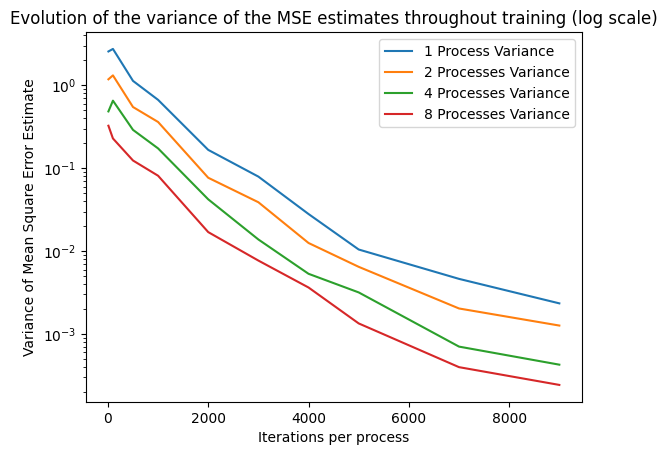

In [307]:
plt.yscale("log")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances1, label = "1 Process Variance")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances2, label = "2 Processes Variance")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances4, label = "4 Processes Variance")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances8, label = "8 Processes Variance")
plt.title("Evolution of the variance of the MSE estimates throughout training (log scale)")
plt.ylabel("Variance of Mean Square Error Estimate")
plt.xlabel("Iterations per process")
plt.legend()
plt.show()

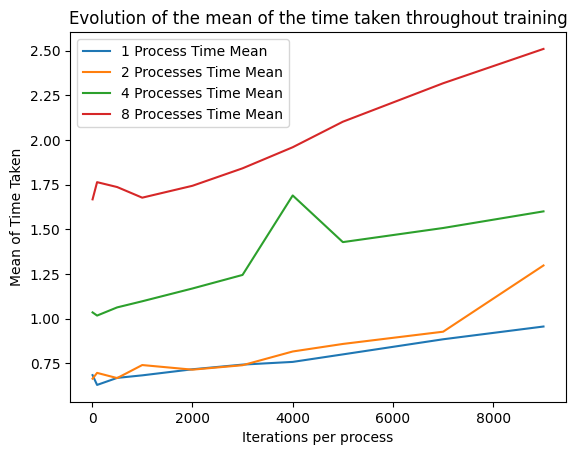

In [314]:
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], times1, label = "1 Process Time Mean")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], times2, label = "2 Processes Time Mean")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], times4, label = "4 Processes Time Mean")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], times8, label = "8 Processes Time Mean")
plt.title("Evolution of the mean of the time taken throughout training")
plt.ylabel("Mean of Time Taken")
plt.xlabel("Iterations per process")
plt.legend()
plt.show()

## Parallelism with threads instead of processes

In [39]:
'''
Conducts Linear Regression but initially transforms data using polynomial basis functions
Takes in an (N * 1) matrix, converts it into a (N * h) matrix
Performs linear regression on the (N*h) matrix resulting in h weights - betas
But this time linear regression is conducted through iterative gradient descent
Specifically stochastic gradient descent where we just choose a single sample from the the dataset

This time t threads conduct sgd in parallel on the entire dataset. 
Each thread does it for n iterations.

After each thread has returned estimates beta_hats, we aggregate them to get the final beta_hat

Returns the predictions only
'''

def lin_reg_poly_sgd_parallel_threads(X, y, h, alpha, n, t):
    start = datetime.now()
    X_poly = polynomial_basis_function_transformation(X, h)
    
    curr1 = datetime.now()
    diff1 = curr1 - start
    
    with ThreadPoolExecutor(max_workers=t) as executor:
        curr2 = datetime.now()
        diff2 = curr2 - curr1
        
        futures = [executor.submit(SGD_Zinkevich.lin_reg_poly_sgd, X_poly, y, h, alpha, n) for _ in range(t)]
        outputs = []
        for future in as_completed(futures):
            outputs.append(future.result())
        outputs = np.array(outputs)
        
        curr3 = datetime.now()
        diff3 = curr3 - curr2
        
    beta_hat_poly = np.sum(outputs, axis=0) / t
    y_hat_poly = X_poly @ beta_hat_poly
    print("mean squared error for linear polynomial through SGD (parallel):", mean_squared_error(y, y_hat_poly))
    print("Times:")
    print(diff1)
    print(diff2)
    print(diff3)
    return y_hat_poly

In [ ]:
lin_reg_poly_sgd_parallel_threads(X, y, 4, 0.0000001, 500, 1)

In [ ]:
lin_reg_poly_sgd_parallel_threads(X, y, 4, 0.0000001, 500000, 2)

In [ ]:
lin_reg_poly_sgd_parallel_threads(X, y, 4, 0.0000001, 500000, 3)

In [ ]:
lin_reg_poly_sgd_parallel_threads(X, y, 4, 0.0000001, 500000, 4)

## Future work
- Comment regularly
- Branch out in git while doing own work and merge back in
- Regularly explain linear algebra/parallelisation algorithm in markdown above cells as he will run code